In [1]:
%matplotlib inline
import numpy as np
import scipy.optimize as optimization
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import matplotlib
import arviz as az
import theano
import ODE_models
import ODE_models_forls
import pandas as pd
import scipy.integrate as integrate
from scipy.integrate import quad
plt.style.use('seaborn-darkgrid')

In [2]:
## Set initial conditions
Nny= .1*19.4e6
# We multiply population of NY state by 1/10 because only 1/10 of cases are detected.

r_newyorkTSV = '../../newyork.tsv'
w_newyorkTSV = '../../newyork.tsv'
tsv_readny = pd.read_csv("newyork.tsv", sep='\t')
confirmed = tsv_readny['confirmed']

#I_S from data will be sum of confirmed today and 6 previous days since gamma = 7.
I_S_from_data = np.zeros(140) 
for i in range(7):
    I_S_from_data[i]=confirmed[i]
for i in range(7,140):
    I_S_from_data[i]=confirmed[i]-confirmed[i-7]
print(confirmed[:10])
print(I_S_from_data[:10])

0      1
1      1
2      2
3     11
4     22
5     44
6     89
7    106
8    142
9    173
Name: confirmed, dtype: int64
[  1.   1.   2.  11.  22.  44.  89. 105. 141. 171.]


In [3]:
#This is where the least squares is claculated for New York
def SEfunc(params):
    #SEfunc is a function that takes the parameters of the ODE models as an input and outputs the least squares value for the function at that time
    #What I need is a fucntion that computes the least squares at the starting points for the values? I.e. if the function
    #remained at those initial guesses
    
    beta_A = params[0]
    q= params[1]
    nu=params[2]
    m = params[3]
    rho = params[4]
    Sa_0 = params[5]
    IS_0ny= params[6]
    
    Sn_0ny = 1-(Sa_0+IS_0ny)
    En_0 = 0
    Ea_0 = 0
    IAn_0 = 0
    IAa_0 = 0
    RS_0  = 0
    RAn_0 = 0
    RAa_0 = 0
    M_0   = 0.01
    
    yobsny = I_S_from_data/Nny
    
    se_params = ODE_models_forls.get_params(beta_A= beta_A, q = q,nu = nu, m=m,rho=rho)
   
    initial_stateny = np.array([Sn_0ny,Sa_0,En_0, Ea_0,IS_0ny,IAn_0,IAa_0,RS_0,RAn_0,RAa_0,M_0])
    timeny = np.arange(0,140,.001)
    timeobsny = np.arange(0,140,1)
    sim_systemny = odeint(ODE_models_forls.SEIRan_system, initial_stateny, timeny, args=(se_params,))
    yny =sim_systemny[:,4]
    
    ypred = np.zeros(140)
    for i in range(0,140):
        ind = np.where(timeny ==i)
        ypred[i] = yny[ind]
    
    SE = (ypred-yobsny)**2
    sumSE = sum(SE)
    return(sumSE)

In [4]:
import random as random
sims = int(1e2)
values = np.zeros((8,sims))
for i in range(0,sims):
    starting_points = np.zeros(7) #beta_A, q, nu, m, rho, S_a(0), I_s(0)
    starting_points[0] = np.random.uniform(0,1)
    starting_points[1] = np.random.uniform(0,.8)
    starting_points[2] = np.random.uniform(0,1)
    starting_points[3] = np.random.uniform(10,100)
    starting_points[4] = np.random.uniform(0,100)
    starting_points[5] = np.random.uniform(0,1)
    starting_points[6] = np.random.uniform(0,.001)
    sum_of_squares = SEfunc(starting_points)
    values[0:7,i] = starting_points[0:7]
    values[7,i] = sum_of_squares
    

/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [5]:
sums_of_squares = list(values[7])
x=min(sums_of_squares)
minimum = sums_of_squares.index(x)
print(minimum)
print(values[:,minimum])
x0_ = values[:,minimum]

15
[8.42094420e-01 5.64328119e-01 2.93172238e-01 9.26917522e+01
 5.41079495e+01 7.52447441e-01 4.06377069e-04 2.33366088e-03]


In [6]:
x0=x0_[:7]

result= optimization.least_squares(SEfunc, x0,bounds=(np.array([0,0,0,10,0,0,0]),np.array([1,1,1,100,100,1,.001])))
print(result)

 active_mask: array([0, 0, 0, 0, 0, 0, 0])
        cost: 1.712019747437937e-06
         fun: array([0.00185042])
        grad: array([ 134.76173906,  134.74872555,  964.14193539,   10.65007846,
         18.66952706, 1010.18258016, 1010.16943232])
         jac: array([[ 72827.8055666 ,  72820.77281798, 521040.62991305,
          5755.50485696,  10089.36732633, 545921.86956559,
        545914.76421914]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 2
        njev: 1
  optimality: 1010.1698268642507
      status: 3
     success: True
           x: array([8.42094420e-01, 5.64328119e-01, 2.93172238e-01, 9.26917522e+01,
       5.41079495e+01, 7.52447441e-01, 4.06377069e-04])


In [7]:
new_params=result['x']
print(new_params)

[8.42094420e-01 5.64328119e-01 2.93172238e-01 9.26917522e+01
 5.41079495e+01 7.52447441e-01 4.06377069e-04]


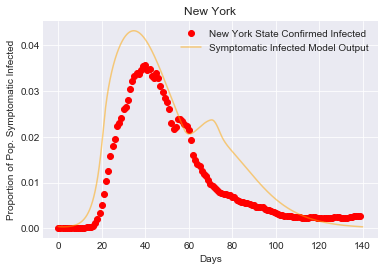

In [8]:
params = ODE_models.get_params(beta_S = 0.7,beta_A= new_params[0], \
    gamma = 1/7,q= new_params[1], nu = new_params[2], m = new_params[3], \
    rho= new_params[4], dealthdelt = 0.02, xi = 1/3, p =1/3)


yobsny = I_S_from_data/Nny
Sn_0ny  = 1-(new_params[5]+new_params[6])
Sa_0  = new_params[5]
En_0 = 0
Ea_0 = 0
IS_0ny  = new_params[6]
IAn_0 = 0
IAa_0 = 0
RS_0  = 0
RAn_0 = 0
RAa_0 = 0
M_0   = 0.01

#newyork
initial_stateny = np.array([Sn_0ny,Sa_0,En_0, Ea_0,IS_0ny,IAn_0,IAa_0,RS_0,RAn_0,RAa_0,M_0])
timeny = np.arange(0,140,.001)
timeobsny = np.arange(0,140,1)
sim_systemny = odeint(ODE_models.SEIRan_system, initial_stateny, timeny, args=(params,))

# computed infected symptomatic
yny =sim_systemny[:,4]

# computed infected symptomatic at intervals of 1 day
ypred = np.zeros(140)
for i in range(0,140):
    ind = np.where(timeny ==i)
    ypred[i] = yny[ind]


plt.plot(timeobsny,yobsny, color= 'red',marker='o', linestyle='none')
plt.plot(timeny, yny, color='orange', alpha=0.5, label=f'$I(t)$')
plt.legend(('New York State Confirmed Infected', 'Symptomatic Infected Model Output'))
plt.title('New York')
plt.xlabel("Days")
plt.ylabel("Proportion of Pop. Symptomatic Infected")
plt.show()

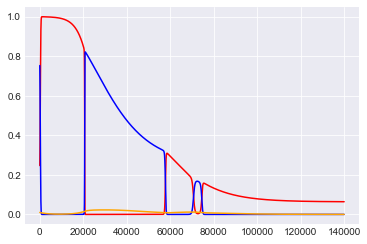

In [9]:
plt.plot(sim_systemny[:,0],color="red")  #susceptibles
plt.plot(sim_systemny[:,1],color="blue")  #infective symptomatic
plt.plot(sim_systemny[:,10],color="orange")  #memory
plt.show()